In [1]:
import pandas as pd
from pysam import VariantFile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

plt.style.use('ggplot')

## Source–[Machine Learning in Bioinformatics: Genome Geography](https://towardsdatascience.com/machine-learning-in-bioinformatics-genome-geography-d1b1dbbfb4c2)

From raw sequencing reads to a machine learning model: an individual's geographical origin is inferred based on their genomic Variation. Read the article to understand variant calling, which is then used for downstream modelling of geographic origin based on VariationVariation. 

In the following two cells, we are downloading already called variants. The process takes some time and may require good computational power. Therefore, we will use the data made available for this tutorial. 

In [ ]:
!mkdir vcf; 
!cd vcf
!curl http://hgdownload.cse.ucsc.edu/gbdb/hg38/1000Genomes/ALL.chr1.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf.gz >ALL.chr1.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf.gz
!curl http://hgdownload.cse.ucsc.edu/gbdb/hg38/1000Genomes/ALL.chr1.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf.gz.tbi >ALL.chr1.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf.gz.tbi
!cd ..

In [ ]:
!mkdir fastq; 
!cd fastq
!curl ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR764/SRR764764/SRR764764_1.fastq.gz >RR764764_1.fastq.gz
!curl ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR764/SRR764764/SRR764764_2.fastq.gz >SRR764764_2.fastq.gz
!cd ..

## Exploratory Analysis

First, let us understand the data available. First, we read the Variant file using Pysam's `VariantFile` function. This allows us to explore the variant file. 

The sample file contains the meta-data. 

In [2]:
samples = pd.read_csv('https://raw.githubusercontent.com/burgshrimps/geogenome/master/1000genomes_phase3.tsv', sep='\t')
vcf = VariantFile('http://hgdownload.cse.ucsc.edu/gbdb/hg38/1000Genomes/ALL.chr1.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf.gz')

First, let us have a look at the columns. 

In [3]:
samples.columns

Index(['Sample name', 'Sex', 'Biosample ID', 'Population code',
       'Population name', 'Superpopulation code', 'Superpopulation name',
       'Data collections'],
      dtype='object')

In [4]:
samples.head()

,Sample name,Sex,Biosample ID,Population code,Population name,Superpopulation code,Superpopulation name,Data collections
0,HG00099,female,SAME123271,GBR,British,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
1,HG00096,male,SAME123268,GBR,British,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
2,HG00102,female,SAME123945,GBR,British,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
3,HG00104,female,SAME123950,GBR,British,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
4,HG00143,male,SAME124393,GBR,British,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."


### Exploring the VCF file
Now that we have read the data into a VFC object, let us see what we have. Let us have a look at the vcf header. 

In [5]:
print(vcf.header)

##fileformat=VCFv4.3
##FILTER=<ID=PASS,Description="All filters passed">
##fileDate=26022019_15h52m43s
##source=IGSRpipeline
##reference=ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/GRCh38_reference_genome/GRCh38_full_analysis_set_plus_decoy_hla.fa
##FORMAT=<ID=GT,Number=1,Type=String,Description="Phased Genotype">
##contig=<ID=1>
##INFO=<ID=AF,Number=A,Type=Float,Description="Estimated allele frequency in the range (0,1)">
##INFO=<ID=AC,Number=A,Type=Integer,Description="Total number of alternate alleles in called genotypes">
##INFO=<ID=NS,Number=1,Type=Integer,Description="Number of samples with data">
##INFO=<ID=AN,Number=1,Type=Integer,Description="Total number of alleles in called genotypes">
##INFO=<ID=EAS_AF,Number=A,Type=Float,Description="Allele frequency in the EAS populations calculated from AC and AN, in the range (0,1)">
##INFO=<ID=EUR_AF,Number=A,Type=Float,Description="Allele frequency in the EUR populations calculated from AC and AN, in the range (0,1)">

In [6]:
len(list((vcf.header.samples)))

2548

We can see that we have 2548 samples in the vcf file, which is why we need to reduce the size of the samples

In [7]:
print(list(vcf.header.info))

['AF', 'AC', 'NS', 'AN', 'EAS_AF', 'EUR_AF', 'AFR_AF', 'AMR_AF', 'SAS_AF', 'VT', 'EX_TARGET', 'DP']


In [8]:
list((vcf.header.contigs))

['1']

In [9]:
list(vcf.header.filters)

['PASS']

In [10]:
for x in vcf.header.records:
    #print (x)
    print (x.type, x.key)

GENERIC fileformat
FILTER FILTER
GENERIC fileDate
GENERIC source
GENERIC reference
FORMAT FORMAT
CONTIG contig
INFO INFO
INFO INFO
INFO INFO
INFO INFO
INFO INFO
INFO INFO
INFO INFO
INFO INFO
INFO INFO
INFO INFO
INFO INFO
INFO INFO


In [36]:
it = 0
for rec in vcf.fetch():
    if it < 2:
        print(list(rec.samples))
        print(list(rec.samples[it]))
        print(rec.samples[it]['GT'])
        it=it+1
    else:
        break

['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101', 'HG00102', 'HG00103', 'HG00104', 'HG00105', 'HG00106', 'HG00107', 'HG00108', 'HG00109', 'HG00110', 'HG00111', 'HG00112', 'HG00113', 'HG00114', 'HG00115', 'HG00116', 'HG00117', 'HG00118', 'HG00119', 'HG00120', 'HG00121', 'HG00122', 'HG00123', 'HG00125', 'HG00126', 'HG00127', 'HG00128', 'HG00129', 'HG00130', 'HG00131', 'HG00132', 'HG00133', 'HG00134', 'HG00135', 'HG00136', 'HG00137', 'HG00138', 'HG00139', 'HG00140', 'HG00141', 'HG00142', 'HG00143', 'HG00145', 'HG00146', 'HG00148', 'HG00149', 'HG00150', 'HG00151', 'HG00152', 'HG00154', 'HG00155', 'HG00156', 'HG00157', 'HG00158', 'HG00159', 'HG00160', 'HG00171', 'HG00173', 'HG00174', 'HG00176', 'HG00177', 'HG00178', 'HG00179', 'HG00180', 'HG00181', 'HG00182', 'HG00183', 'HG00185', 'HG00186', 'HG00187', 'HG00188', 'HG00189', 'HG00190', 'HG00231', 'HG00232', 'HG00233', 'HG00234', 'HG00235', 'HG00236', 'HG00237', 'HG00238', 'HG00239', 'HG00240', 'HG00242', 'HG00243', 'HG00244', 'HG00245'

# Reduce number of samples using stratified sampling

Since we are working with a huge amount of data, let's sample a few for downstream modelling. This will save on computational resources needed. 

In [11]:
vcf.header.version

'VCFv4.3'

In [12]:
samples = samples[samples['Sample name'].isin(list(vcf.header.samples))]
samples['Superpopulation code'].value_counts()

AFR    666
EUR    517
EAS    508
SAS    492
AMR    347
Name: Superpopulation code, dtype: int64

Let's have a look what is in the dataFrame. We have 2530 samples in the file

In [13]:
len(samples)

2530

In [85]:
pd.DataFrame(samples.groupby('Superpopulation code'))

,0,1
0,AFR,Sample name Sex Biosample ID Populati...
1,AMR,Sample name Sex Biosample ID Populati...
2,EAS,Sample name Sex Biosample ID Populati...
3,EUR,Sample name Sex Biosample ID Populati...
4,SAS,Sample name Sex Biosample ID Populati...


In [86]:
samples_subset = samples.groupby('Superpopulation code').apply(lambda x: x.sample(n=50))
samples_subset.reset_index(drop=True, inplace=True)
#samples_subset.to_csv('samples_subset.tsv', sep='\t', index=False)
num_samples = len(samples_subset)

In [16]:
#samples_subset = samples.groupby('Superpopulation code').apply(lambda x: x.sample(n=20))

In [87]:
samples_subset

,Sample name,Sex,Biosample ID,Population code,Population name,Superpopulation code,Superpopulation name,Data collections
0,NA19438,female,SAME123848,LWK,Luhya,AFR,African,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
1,NA19379,female,SAME125092,LWK,Luhya,AFR,African,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
2,HG03084,male,SAME1840324,MSL,Mende,AFR,African,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
3,NA19921,female,SAME124712,ASW,African-American SW,AFR,African,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
4,HG03077,male,SAME1839044,MSL,Mende,AFR,African,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
...,...,...,...,...,...,...,...,...
245,NA21127,male,SAME124027,GIH,Gujarati,SAS,South Asian,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
246,HG03812,male,SAME1839405,BEB,Bengali,SAS,South Asian,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
247,HG03943,male,SAME1840361,STU,Sri Lankan,SAS,South Asian,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
248,HG03684,female,SAME1840329,STU,Sri Lankan,SAS,South Asian,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."


In [18]:
#vcf.subset_samples(list(samples_subset['Sample name']))

# Compute Hamming Distance between subset of samples

In [88]:
num_mismatches = np.zeros((num_samples, num_samples))
num_snps = 0

In [91]:
for rec in vcf.fetch():
    all_homref = True
    tmp_mismatches = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        if rec.samples[i]['GT'] != (0,0):
            all_homref = False
        for j in range(i, num_samples):
            #print(rec.samples[i]['GT'])
            #print(rec.samples[j]['GT'])
            if (rec.samples[i]['GT'] != rec.samples[j]['GT']) & (rec.samples[i]['GT'] != rec.samples[j]['GT'][::-1]):
                tmp_mismatches[i,j] += 1
    if not all_homref:
        num_mismatches += tmp_mismatches
        num_snps += 1

OSError: unable to parse next record

In [92]:
num_mismatches

array([[  0., 288., 197., ..., 317., 226., 350.],
       [  0.,   0., 283., ..., 335., 364., 310.],
       [  0.,   0.,   0., ..., 268., 230., 304.],
       ...,
       [  0.,   0.,   0., ...,   0., 328.,  83.],
       [  0.,   0.,   0., ...,   0.,   0., 351.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [93]:
num_snps

1708

In [94]:
ham_dist = num_mismatches / num_snps
ham_dist = np.triu(ham_dist) + np.tril(ham_dist.T) # Make matrix balanced
np.savetxt('ham_dist.txt', ham_dist, delimiter='\t', fmt='%1.3f')

In [ ]:
!pip install pysam

# Load pre-computed files

In [14]:
vcf = VariantFile('http://hgdownload.cse.ucsc.edu/gbdb/hg38/1000Genomes/ALL.chr1.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf.gz')
samples_subset = pd.read_csv('https://raw.githubusercontent.com/burgshrimps/geogenome/master/samples_subset.tsv', sep='\t')
ham_dist = np.loadtxt('https://raw.githubusercontent.com/burgshrimps/geogenome/master/ham_dist.txt')

In [15]:
vcf.subset_samples(list(samples_subset['Sample name']))

In [16]:
sorterIndex = dict(zip(list(vcf.header.samples), range(len(list(vcf.header.samples)))))
samples_subset['Rank'] = samples_subset['Sample name'].map(sorterIndex)
samples_subset.sort_values('Rank', inplace=True)
samples_subset.drop('Rank', axis=1, inplace=True)

In [17]:
samples_subset

,Sample name,Sex,Biosample ID,Population code,Population name,Superpopulation code,Superpopulation name,Data collections
70,HG00109,male,SAME125160,GBR,British,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
60,HG00129,male,SAME122867,GBR,British,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
67,HG00271,male,SAME123417,FIN,Finnish,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
74,HG00290,male,SAME1839057,FIN,Finnish,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
69,HG00342,male,SAME124924,FIN,Finnish,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
...,...,...,...,...,...,...,...,...
91,NA21102,female,SAME124438,GIH,Gujarati,SAS,South Asian,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
82,NA21108,female,SAME124442,GIH,Gujarati,SAS,South Asian,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
90,NA21120,female,SAME124028,GIH,Gujarati,SAS,South Asian,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
98,NA21127,male,SAME124027,GIH,Gujarati,SAS,South Asian,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."


In [18]:
df = pd.DataFrame(ham_dist)

In [19]:
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000,0.148,0.154,0.155,0.152,0.154,0.153,0.169,0.168,0.189,...,0.151,0.152,0.160,0.161,0.161,0.159,0.162,0.161,0.160,0.161
1,0.148,0.000,0.152,0.149,0.152,0.151,0.151,0.167,0.167,0.188,...,0.149,0.150,0.157,0.159,0.157,0.160,0.156,0.162,0.158,0.159
2,0.154,0.152,0.000,0.148,0.153,0.149,0.154,0.164,0.166,0.189,...,0.152,0.155,0.159,0.163,0.161,0.160,0.161,0.160,0.162,0.160
3,0.155,0.149,0.148,0.000,0.151,0.149,0.154,0.165,0.166,0.187,...,0.154,0.152,0.159,0.161,0.161,0.160,0.162,0.160,0.159,0.160
4,0.152,0.152,0.153,0.151,0.000,0.153,0.152,0.167,0.166,0.189,...,0.152,0.152,0.159,0.159,0.161,0.164,0.162,0.165,0.160,0.162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.159,0.160,0.160,0.160,0.164,0.165,0.161,0.165,0.167,0.191,...,0.158,0.157,0.161,0.159,0.157,0.000,0.159,0.158,0.159,0.159
96,0.162,0.156,0.161,0.162,0.162,0.160,0.160,0.166,0.163,0.191,...,0.157,0.161,0.159,0.159,0.158,0.159,0.000,0.159,0.157,0.160
97,0.161,0.162,0.160,0.160,0.165,0.165,0.163,0.166,0.168,0.190,...,0.161,0.161,0.158,0.157,0.156,0.158,0.159,0.000,0.159,0.158
98,0.160,0.158,0.162,0.159,0.160,0.163,0.161,0.164,0.162,0.193,...,0.160,0.161,0.155,0.159,0.155,0.159,0.157,0.159,0.000,0.161


In [20]:
df[['sample', 'superpop', 'pop']] = samples_subset[['Sample name', 'Superpopulation code', 'Population code']].reset_index(drop=True)

In [21]:
df = df.rename(columns=dict(zip(range(100), list(samples_subset['Sample name']))))
df = df.set_index('sample')

In [22]:
df

,HG00109,HG00129,HG00271,HG00290,HG00342,HG00378,HG00384,HG00404,HG00766,HG01063,...,NA20852,NA20881,NA20884,NA21102,NA21108,NA21120,NA21127,NA21128,superpop,pop
sample,,,,,,,,,,,,,,,,,,,,,
HG00109,0.000,0.148,0.154,0.155,0.152,0.154,0.153,0.169,0.168,0.189,...,0.160,0.161,0.161,0.159,0.162,0.161,0.160,0.161,EUR,GBR
HG00129,0.148,0.000,0.152,0.149,0.152,0.151,0.151,0.167,0.167,0.188,...,0.157,0.159,0.157,0.160,0.156,0.162,0.158,0.159,EUR,GBR
HG00271,0.154,0.152,0.000,0.148,0.153,0.149,0.154,0.164,0.166,0.189,...,0.159,0.163,0.161,0.160,0.161,0.160,0.162,0.160,EUR,FIN
HG00290,0.155,0.149,0.148,0.000,0.151,0.149,0.154,0.165,0.166,0.187,...,0.159,0.161,0.161,0.160,0.162,0.160,0.159,0.160,EUR,FIN
HG00342,0.152,0.152,0.153,0.151,0.000,0.153,0.152,0.167,0.166,0.189,...,0.159,0.159,0.161,0.164,0.162,0.165,0.160,0.162,EUR,FIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA21102,0.159,0.160,0.160,0.160,0.164,0.165,0.161,0.165,0.167,0.191,...,0.161,0.159,0.157,0.000,0.159,0.158,0.159,0.159,SAS,GIH
NA21108,0.162,0.156,0.161,0.162,0.162,0.160,0.160,0.166,0.163,0.191,...,0.159,0.159,0.158,0.159,0.000,0.159,0.157,0.160,SAS,GIH
NA21120,0.161,0.162,0.160,0.160,0.165,0.165,0.163,0.166,0.168,0.190,...,0.158,0.157,0.156,0.158,0.159,0.000,0.159,0.158,SAS,GIH


# Plot Heatmap of Hamming Distances

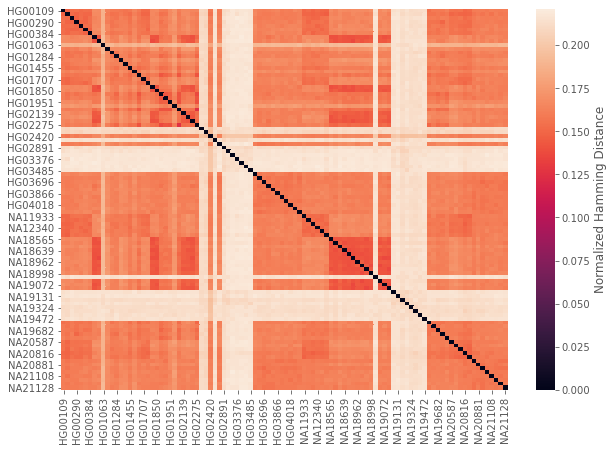

In [23]:
plt.figure(figsize=(10,7))
sns.heatmap(df.drop(['superpop', 'pop'], axis=1), cbar_kws={'label': 'Normalized Hamming Distance'})
plt.ylabel('')
plt.show()

# Dimensionality Reduction with tSNE

What is dimensionality reduction?

In [24]:
tsne = TSNE(n_components=2)

In [25]:
transformed = tsne.fit_transform(df.drop(['superpop', 'pop'], axis=1))

In [26]:
df_tsne = pd.DataFrame(transformed, columns=['C1', 'C2'])
df_tsne[['superpop', 'pop']] = df[['superpop', 'pop']].reset_index(drop=True)

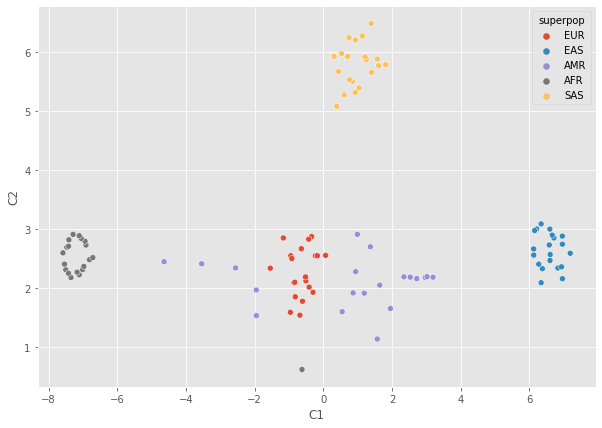

In [27]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='C1', y='C2', data=df_tsne, hue='superpop')
plt.show()

# Multinomial Classification

In [28]:
X, y = df.drop(['superpop', 'pop'], axis=1), df['superpop']

In [29]:
X

,HG00109,HG00129,HG00271,HG00290,HG00342,HG00378,HG00384,HG00404,HG00766,HG01063,...,NA20816,NA20827,NA20852,NA20881,NA20884,NA21102,NA21108,NA21120,NA21127,NA21128
sample,,,,,,,,,,,,,,,,,,,,,
HG00109,0.000,0.148,0.154,0.155,0.152,0.154,0.153,0.169,0.168,0.189,...,0.151,0.152,0.160,0.161,0.161,0.159,0.162,0.161,0.160,0.161
HG00129,0.148,0.000,0.152,0.149,0.152,0.151,0.151,0.167,0.167,0.188,...,0.149,0.150,0.157,0.159,0.157,0.160,0.156,0.162,0.158,0.159
HG00271,0.154,0.152,0.000,0.148,0.153,0.149,0.154,0.164,0.166,0.189,...,0.152,0.155,0.159,0.163,0.161,0.160,0.161,0.160,0.162,0.160
HG00290,0.155,0.149,0.148,0.000,0.151,0.149,0.154,0.165,0.166,0.187,...,0.154,0.152,0.159,0.161,0.161,0.160,0.162,0.160,0.159,0.160
HG00342,0.152,0.152,0.153,0.151,0.000,0.153,0.152,0.167,0.166,0.189,...,0.152,0.152,0.159,0.159,0.161,0.164,0.162,0.165,0.160,0.162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA21102,0.159,0.160,0.160,0.160,0.164,0.165,0.161,0.165,0.167,0.191,...,0.158,0.157,0.161,0.159,0.157,0.000,0.159,0.158,0.159,0.159
NA21108,0.162,0.156,0.161,0.162,0.162,0.160,0.160,0.166,0.163,0.191,...,0.157,0.161,0.159,0.159,0.158,0.159,0.000,0.159,0.157,0.160
NA21120,0.161,0.162,0.160,0.160,0.165,0.165,0.163,0.166,0.168,0.190,...,0.161,0.161,0.158,0.157,0.156,0.158,0.159,0.000,0.159,0.158


In [30]:
y

sample
HG00109    EUR
HG00129    EUR
HG00271    EUR
HG00290    EUR
HG00342    EUR
          ... 
NA21102    SAS
NA21108    SAS
NA21120    SAS
NA21127    SAS
NA21128    SAS
Name: superpop, Length: 100, dtype: object

In [32]:
rf = RandomForestClassifier()
nb = MultinomialNB()
knn = KNeighborsClassifier()
lgr = LogisticRegression(multi_class='multinomial')

In [33]:
classifiers = [rf, nb, knn, lgr]
scores = np.array([])
k = 5
for clf in classifiers:
    scores = np.append(scores, cross_val_score(clf, X, y, cv=k)[:])
classifier_labels = []
for label in ['RF', 'NB', 'KNN', 'LGR']:
    classifier_labels += [label] * k

In [34]:
scores

array([0.95, 1.  , 1.  , 1.  , 1.  , 0.85, 0.85, 1.  , 0.9 , 0.85, 0.85,
       0.9 , 1.  , 1.  , 0.95, 0.8 , 0.85, 0.8 , 0.85, 0.8 ])

In [35]:
df_scores = pd.DataFrame([scores, classifier_labels], index=['Accuracy', 'Classifier'])
df_scores = df_scores.T

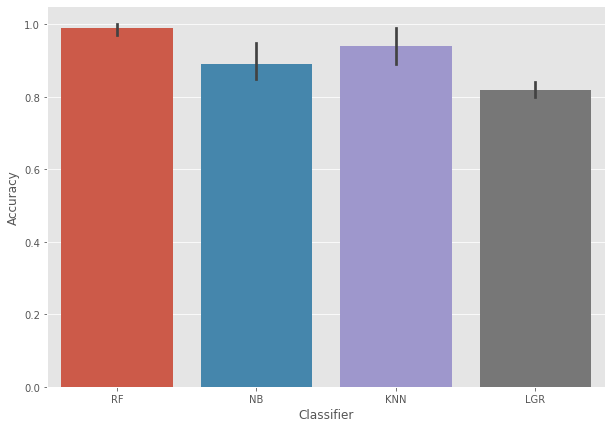

In [36]:
plt.figure(figsize=(10,7))
sns.barplot(x='Classifier', y='Accuracy', data=df_scores)
plt.show()